# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import json
import re
import os, cv2
import numpy as np
import matplotlib.pyplot as plt
import glob

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras import backend as K
K.set_image_data_format('channels_last') 
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.regularizers import l1, l2

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score

import h5py


# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Unzip Data in Google Drive

In [ ]:
# !unzip '/content/drive/MyDrive/Deep Learning Semester Project /Facebook Hateful Memes Challenge.zip' -d '/content/drive/MyDrive/Deep Learning Semester Project /Dataset'  

In [ ]:
# read Label files

# Read Json Label and Text Files

In [ ]:
import json
with open('/content/drive/MyDrive/Dataset/data/train.jsonl') as f:
    train_label_data = [json.loads(line) for line in f]

In [ ]:
with open('/content/drive/MyDrive/Dataset/data/dev.jsonl') as f:
    dev_label_data = [json.loads(line) for line in f]

In [ ]:
df_text = pd.concat([pd.DataFrame(train_label_data), pd.DataFrame(dev_label_data)])  

# Preprocessing Of Text Data

In [ ]:
import spacy
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop = stopwords.words('english')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def clean_text(text):
    text = re.sub('[^ a-zA-Z0-9]', '', text) 
    text = re.sub(r"\W"," ",text)
    text = re.sub(r"\d"," ",text)
    text = re.sub(r"\s+[a-z]\s+"," ",text)
    text = re.sub(r"\s+[a-z]$"," ",text)
    text = re.sub(r"^[a-z]\s+"," ",text)
    text = re.sub(r"\s+"," ",text) 
    return  text

nlp = spacy.blank('en')
def tokenizer(sent):    
    doc = nlp.tokenizer(sent)
    return [i.text for i in doc]

In [ ]:
df_text['preprocessed'] = df_text['text'].str.lower()
df_text['preprocessed'] = df_text['preprocessed'].apply(clean_text)
df_text['preprocessed'] = df_text['preprocessed'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_text["preprocessed"] = df_text["preprocessed"].apply(tokenizer)
df_text['len']  = df_text['preprocessed'].str.len()

In [ ]:
print('Maximum Length of a sentence after cleaning: ', df_text['len'].max() )

Maximum Length of a sentence after cleaning:  45


In [ ]:
df_text.head()

,id,img,label,text,preprocessed,len
0,42953,img/42953.png,0,its their character not their color that matters,"[character, color, matters]",3
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...,"[do, nt, afraid, love, everyone, like, ex]",7
2,13894,img/13894.png,0,putting bows on your pet,"[putting, bows, pet]",3
3,37408,img/37408.png,0,i love everything and everybody! except for sq...,"[love, everything, everybody, except, squirrel...",7
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h...","[everybody, loves, chocolate, chip, cookies, e...",7


# Reading Image Data with Text data

In [ ]:
images = []
labels = []
text = []

for index, row in df_text.iterrows():
    print(index)

    if index == 4000:
      break
    input_image = cv2.imread('/content/drive/MyDrive/Dataset/data/' + str(row['img']))

    input_image = cv2.resize(input_image, (299,299))
    input_image = (input_image/255.0).astype(np.float32)
    
    images.append(input_image)
    labels.append(row['label'])
    text.append(row['preprocessed'])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
len(images), len(labels), len(text)

(4000, 4000, 4000)

# Preprocess Image Data

In [ ]:
len(images), len(labels), len(text)


(4000, 4000, 4000)

In [ ]:
y = pd.Series(labels)
y = pd.get_dummies(y)

# Split Data into Training and testing

In [ ]:
from collections import Counter
Counter(labels)

Counter({0: 2656, 1: 1344})

In [ ]:
Train_Image, Test_Image , Train_Text , Test_Text, Train_Label, Test_Label  = train_test_split(images, text, y, test_size = 0.25 , shuffle = True)

In [ ]:
del images , text, labels

In [ ]:
Train_Image = np.array(Train_Image)
Test_Image =  np.array(Test_Image)

In [ ]:
train_vecs = [" ".join(x) for x in Train_Text]
test_vecs = [" ".join(x) for x in Test_Text]

In [ ]:
# Train Text Embeddings with TF-IDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
max_feature_num = 10000
vectorizer = TfidfVectorizer(max_features=max_feature_num)
train_vecs = vectorizer.fit_transform(np.array(train_vecs))

In [ ]:
test_vecs = TfidfVectorizer(max_features=max_feature_num, vocabulary=vectorizer.vocabulary_).fit_transform(np.array(test_vecs))

In [ ]:
vectorizer.vocabulary_

In [ ]:
# Save Vocab to for Prediction in Future
import pickle
pickle.dump(vectorizer, open("/content/drive/MyDrive/tfidf_vectorizer.pkl", "wb"))

In [ ]:
# trainvecs
train_vecs = train_vecs.toarray()
train_vecs = np.asarray(train_vecs).astype(float)

# test_vecs
test_vecs = test_vecs.toarray()
test_vecs = np.asarray(test_vecs).astype(float)

In [ ]:
train_vecs.shape

(3000, 5088)

# Model Fusion of InceptionV3 and TF-IDF Vectorizer

In [ ]:
import keras
import numpy as np
from keras.layers import Dropout
from keras.applications.inception_v3 import InceptionV3 
from keras.layers import Dense, GlobalAveragePooling2D, merge, Input
from keras.models import Model

epochs = 5
batch_size = 32


# Text input branch - just a simple MLP
text_inputs = Input(shape=(5088,))
branch_1 = Dense(512, activation='relu')(text_inputs)

# Image input branch - a pre-trained Inception module followed by an added fully connected layer
base_model = InceptionV3(weights='imagenet', include_top=False)
# Freeze Inception's weights - we don't want to train these
for layer in base_model.layers:
    layer.trainable = False

# add a fully connected layer after Inception - we do want to train these
branch_2 = base_model.output
branch_2 = GlobalAveragePooling2D()(branch_2)
branch_2 = Dense(512, activation='relu')(branch_2)

# merge the text input branch and the image input branch and add another fully connected layer
joint = keras.layers.concatenate([branch_1, branch_2])
joint = Dense(1024, activation='relu')(joint)
joint = Dropout(0.5)(joint)
joint = Dense(512, activation='relu')(joint)
joint = Dropout(0.5)(joint)
predictions = Dense(2, activation='sigmoid')(joint)

full_model = Model(inputs=[base_model.input, text_inputs], outputs=[predictions])

full_model.compile(loss='categorical_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])


87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
history = full_model.fit([Train_Image, train_vecs], np.array(Train_Label),
                         epochs=epochs, batch_size=batch_size,
                        verbose=1, validation_split = 0.20 ,class_weight = {0:25., 1:50.},   shuffle=True)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/5
75/75 [==============================] - 78s 257ms/step - loss: 29.2888 - accuracy: 0.5108 - val_loss: 0.7312 - val_accuracy: 0.3617
Epoch 2/5
75/75 [==============================] - 11s 151ms/step - loss: 21.7123 - accuracy: 0.6092 - val_loss: 0.7929 - val_accuracy: 0.4750
Epoch 3/5
75/75 [==============================] - 11s 154ms/step - loss: 11.1659 - accuracy: 0.8622 - val_loss: 0.9379 - val_accuracy: 0.5583
Epoch 4/5
75/75 [==============================] - 12s 155ms/step - loss: 5.2142 - accuracy: 0.9378 - val_loss: 1.0755 - val_accuracy: 0.5600
Epoch 5/5
75/75 [==============================] - 12s 156ms/step - loss: 3.7635 - accuracy: 0.9468 - val_loss: 1.1817 - val_accuracy: 0.5683


In [ ]:
del Train_Image, train_vecs, Train_Label

# Results

In [ ]:
# prediction on Testing Set
prediction_latefusion = full_model.predict([Test_Image, test_vecs]).round()

In [ ]:
prediction_latefusion

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [ ]:
print(classification_report(prediction_latefusion, Test_Label))

              precision    recall  f1-score   support

           0       0.60      0.75      0.67       555
           1       0.58      0.37      0.45       471

   micro avg       0.59      0.58      0.58      1026
   macro avg       0.59      0.56      0.56      1026
weighted avg       0.59      0.58      0.57      1026
 samples avg       0.59      0.58      0.58      1026



In [ ]:
# model saving 
from keras.models import model_from_json
from keras.models import load_model

In [ ]:
# serialize model to JSON
model_json = full_model.to_json()
with open("/content/drive/MyDrive/latefusion_Inception_tfidf.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
full_model.save_weights("/content/drive/MyDrive/latefusion_Inception_tfidf.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# load json and create model
json_file = open('/content/drive/MyDrive/latefusion_Inception_tfidf.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/latefusion_Inception_tfidf.h5")
print("Loaded model from disk")
    
loaded_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )   


Loaded model from disk


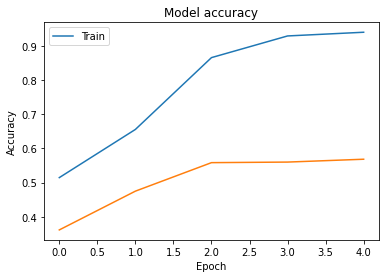

In [ ]:
#Accuracy Curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

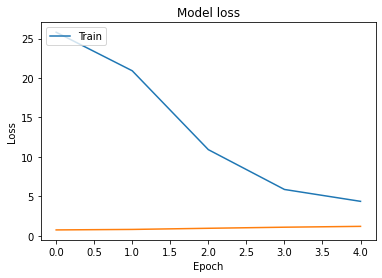

In [ ]:
#Loss Curve
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(Test_Label, prediction_latefusion)

0.5740890939365169

In [ ]:
#ROC Curve AUC
from sklearn.metrics import roc_curve
# y_pred = full_model.predict([Test_Image, test_vecs])
fpr, tpr, thresholds = roc_curve(Test_Label, prediction_latefusion)

from sklearn.metrics import auc
auc = auc(fpr, tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LSTM (area = {:.3f})'.format(auc))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

ValueError: ignored